## Import packages, including multipopulation extensions

In [1]:
#### General packages

from matplotlib import pyplot as plt
%matplotlib inline
import autograd.numpy as np
import autograd.numpy.random as npr

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
sns.set_style('ticks',{"xtick.major.size":8,
"ytick.major.size":8})
from ssm.plots import gradient_cmap, white_to_color_cmap

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [2]:
#### SSM PACKAGES ###

import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior, \
	SLDSStructuredMeanFieldVariationalPosterior
from ssm.util import random_rotation, find_permutation, relu

#Load from extensions
from extensions.mp_srslds.emissions_ext import GaussianOrthogonalCompoundEmissions, PoissonOrthogonalCompoundEmissions
from extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions, StickyRecurrentTransitions

## Simulate (somewhat realistic) data

### Set parameters of simulation

In [3]:
K=3 #Number of discrete states

num_gr=3 #Number of populations
num_per_gr=5 #Number of latents per population
neur_per_gr=75 #Number of neurons per population

t_end=3000 #number of time bins
num_trials=1 #number of trials

In [4]:
np.random.seed(108) #To create replicable dynamics

alphas=.03+.1*np.random.rand(K) #Determines the distribution of values in the dynamics matrix, for each discrete state
print('alphas:', alphas)

sparsity=.33 #Proportion of non-diagonal blocks in the dynamics matrix that are 0

e1=.1 #Amount of noise in the dynamics

alphas: [0.05336111 0.03343876 0.08800889]


### Get new emissions and transitions classes for the simulated data

In [5]:
#Vector containing number of latents per population
D_vec=[]
for i in range(num_gr):
    D_vec.append(num_per_gr) 

#Vector containing number of neurons per population
N_vec=[]
for i in range(num_gr):
    N_vec.append(neur_per_gr)

D=np.sum(D_vec)
num_gr=len(D_vec)
D_vec_cumsum = np.concatenate(([0], np.cumsum(D_vec)))

#Get new multipopulation emissions class for the simulation

# gauss_comp_emissions=GaussianOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec)
poiss_comp_emissions=PoissonOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec,link='softplus')

#Get transitions class
true_sro_trans=StickyRecurrentOnlyTransitions(K=K,D=np.sum(D_vec)) 

### Create simulated data

In [6]:
np.random.seed(10) #To create replicable simulations

A_masks=[]

A_all=np.zeros([K,D,D]) #Initialize dynamics matrix
b_all=np.zeros([K,D]) #Initialize dynamics offset


#Create initial ground truth model, that we will modify
true_slds = ssm.SLDS(N=np.sum(N_vec),K=K,D=int(np.sum(D_vec)),
             dynamics="gaussian",
             emissions=poiss_comp_emissions,
             transitions=true_sro_trans)

#Create ground truth transitions
v=.2+.2*np.random.rand(1)
for k in range(K):
    inc=np.copy(k)
    true_slds.transitions.Rs[k,D_vec_cumsum[inc]:D_vec_cumsum[inc]+1]=v
    true_slds.transitions.Ss[k,D_vec_cumsum[inc]:D_vec_cumsum[inc]+1]=v-.1

true_slds.transitions.r=0*np.ones([K,1])
true_slds.transitions.s=5*np.ones([K,1])

#Create ground truth dynamics for each state
for k in range(K):

    ##Create dynamics##
    alpha=alphas[k]

    A_mask=np.random.rand(num_gr,num_gr)>sparsity #Make some blocks of the dynamics matrix 0

    A_masks.append(A_mask)

    for i in range(num_gr): 
        A_mask[i,i]=1

    A0=np.zeros([D,D])
    for i in range(D-1):
        A0[i,i+1:]=alpha*np.random.randn(D-1-i)
    A0=(A0-A0.T)

    for i in range(num_gr):
        A0[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[i]:D_vec_cumsum[i+1]]=2*A0[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[i]:D_vec_cumsum[i+1]]


    A0=A0+np.identity(D)
    A=A0*np.kron(A_mask, np.ones((num_per_gr, num_per_gr)))

    A=A/(np.max(np.abs(np.linalg.eigvals(A)))+.01) #.97

    b=1*np.random.rand(D)

    A_all[k]=A
    b_all[k]=b

true_slds.dynamics.As=A_all
true_slds.dynamics.bs=b_all


zs, xs, _ = true_slds.sample(t_end) #Sample discrete and continuous latents from model for simulation

#Get spike trains that have an average firing rate of 0.25 per bin
tmp=np.mean(relu(np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T)
mult=.25/tmp
lams=relu(mult*np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T
ys=np.random.poisson(lams) #Get spiking activity based on poisson statistics

## Plot simulated data

### Dynamics matrices

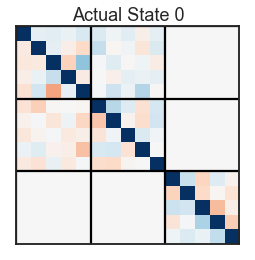

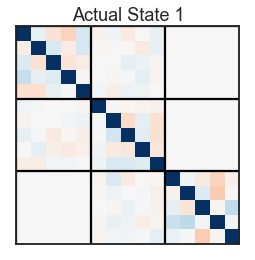

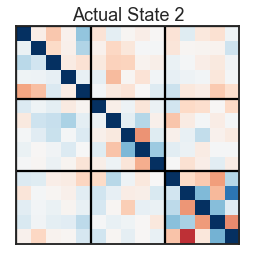

In [7]:
# vmin,vmax=[-1,1]
vmin,vmax=[-.5,.5] #zoom in to see colors more clearly


for k in range(K):
    
    plt.figure(figsize=(4,4))
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=vmin, vmax=vmax, cmap='RdBu')
    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Actual State '+str(k))

### Discrete states

([], <a list of 0 Text yticklabel objects>)

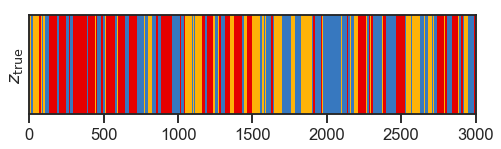

In [8]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

### Transitions (in a shorter time window)

In [9]:
dur=200
st_t=650
end_t=st_t+dur

([], <a list of 0 Text yticklabel objects>)

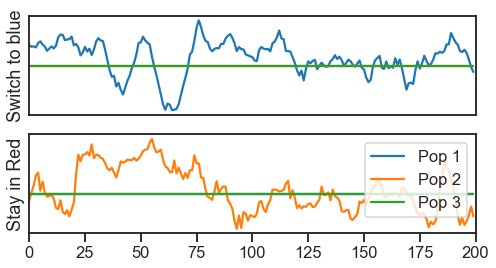

In [10]:
plt.figure(figsize=(8, 4))

j=0

plt.subplot(211)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Switch to blue')
plt.xticks([])
plt.yticks([])

j=1
plt.subplot(212)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Ss[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Stay in Red')
plt.legend(['Pop 1','Pop 2','Pop 3'])
plt.yticks([])

### Latents and spikes for an example population

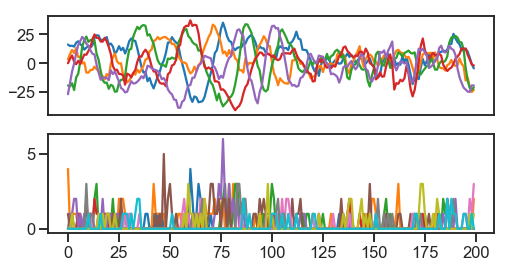

In [11]:
plt.figure(figsize=(8, 4))

plt.subplot(211)
plt.plot(xs[st_t:end_t,:num_per_gr]) #Show latents of first group
plt.xticks([])

plt.subplot(212)
plt.plot(ys[st_t:end_t,:10]) #Show first 10 neurons


## Fit model to data

#### To create the emissions classes for the multipopulation models, we need vectors containing the number of latents and neurons per population


In [12]:
#Vector containing number of latents per population
D_vec=[]
for i in range(num_gr):
    D_vec.append(num_per_gr) 

#Vector containing number of neurons per population
N_vec=[]
for i in range(num_gr):
    N_vec.append(neur_per_gr)

#### Now create the multipopulation emissions and transitions classes for our model

In [13]:
#Get new multipopulation emissions class
poiss_comp_emissions=PoissonOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec,link='softplus')

#Get new transitions class
sro_trans=StickyRecurrentOnlyTransitions(K=K,D=np.sum(D_vec), l2_penalty_similarity=10, l1_penalty=10) 
#The above l2 penalty is on the similarity between R and S (its assuming the activity to switch into a state is similar to activity to stay in a state)
#The L1 penalty is on the entries of R and S

#### Now declare and fit the model

In [14]:
rslds = ssm.SLDS(N=np.sum(N_vec),K=K,D=np.sum(D_vec),
             dynamics="gaussian",
             emissions=poiss_comp_emissions,
             transitions=sro_trans,
             dynamics_kwargs=dict(l2_penalty_A=100)) #Regularization on the dynamics matrix

rslds.initialize(ys,init='ar_clust', t_win=10)
# rslds.initialize(ys)

q_elbos_ar, q_ar = rslds.fit(ys, method="laplace_em",
                               variational_posterior="structured_meanfield", continuous_optimizer='newton',
                               initialize=False, num_iters=30, alpha=0.25)

Initializing with an ARHMM using 25 steps of EM.
initialization method is: ar_clust
t_win: 10
t_gap: 4


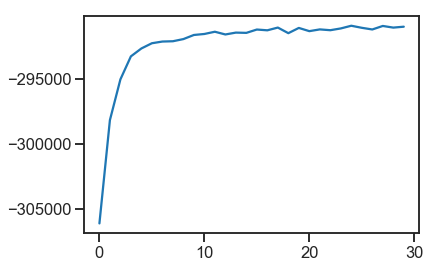

In [15]:
plt.plot(q_elbos_ar[1:])

## Plot results

### Discrete states

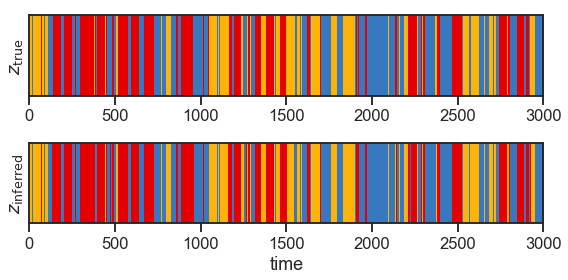

In [16]:
#Find permutation to match the discrete states in the model and the ground truth
z_inferred=rslds.most_likely_states(q_ar.mean_continuous_states[0],ys)
rslds.permute(find_permutation(zs, z_inferred))
z_inferred2=rslds.most_likely_states(q_ar.mean_continuous_states[0],ys)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [17]:
print('Discrete state accuracy: ', np.mean(zs==z_inferred2))

Discrete state accuracy:  0.9746666666666667


#### Shorter time window

([], <a list of 0 Text yticklabel objects>)

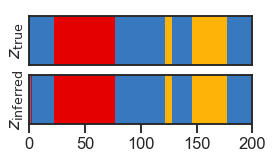

In [18]:
plt.figure(figsize=(4, 2))
plt.subplot(211)
plt.imshow(zs[None,st_t:end_t], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, dur)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.xticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,st_t:end_t], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, dur)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])

### Dynamics

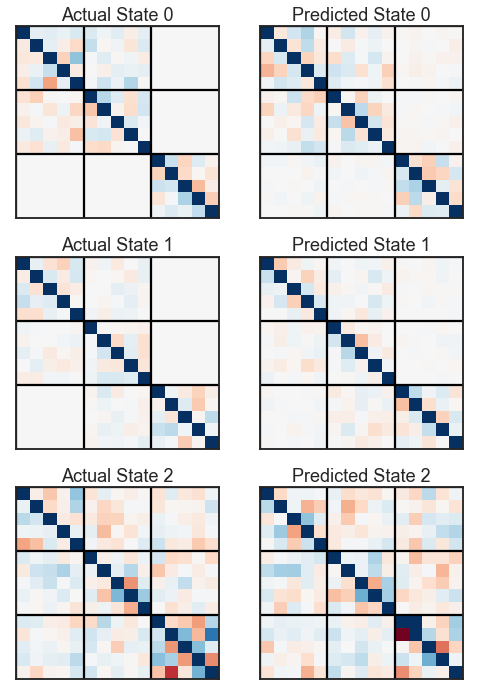

In [19]:
plt.figure(figsize=(8, 12))

q=1

for k in range(K):
    
    plt.subplot(3,2,q)
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Actual State '+str(k))
    
    q=q+1
    
    
    plt.subplot(3,2,q)
    plt.imshow(rslds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted State '+str(k))
#     plt.savefig(folder+'dyn_est'+str(k)+'.pdf')
    
    q=q+1
    


### Transitions

([], <a list of 0 Text yticklabel objects>)

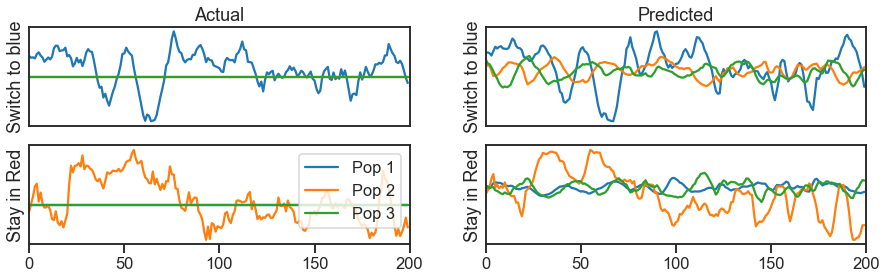

In [20]:
plt.figure(figsize=(15, 4))


### Actual

j=0

plt.subplot(221)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Switch to blue')
plt.xticks([])
plt.yticks([])
plt.title('Actual')

j=1
plt.subplot(223)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Ss[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Stay in Red')
plt.legend(['Pop 1','Pop 2','Pop 3'])
plt.yticks([])




### Predicted

j=0

plt.subplot(222)
for g in range(K):
    plt.plot(np.dot(q_ar.mean_continuous_states[0][st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],rslds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Switch to blue')
plt.xticks([])
plt.yticks([])
plt.title('Predicted')

j=1
plt.subplot(224)
for g in range(K):
    plt.plot(np.dot(q_ar.mean_continuous_states[0][st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],rslds.transitions.Ss[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Stay in Red')
# plt.xticks([])
plt.yticks([])

### Example fit of neural activity

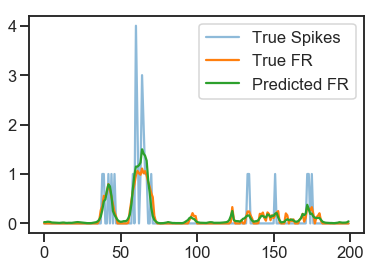

In [21]:
preds=rslds.smooth(q_ar.mean_continuous_states[0],ys) #get predictions

nrn=0 #Example neuron
plt.plot(ys[st_t:end_t,nrn],alpha=.5) #true spiking activity
plt.plot(lams[st_t:end_t,nrn]) #true firing rate
plt.plot(preds[st_t:end_t,nrn]) #predicted firing

plt.legend(['True Spikes','True FR','Predicted FR'])
